In [2]:
import json
import pandas as pd

In [3]:
result_dir_path = 'data/trivia_qa_wiki/results/llama-2-7b-chat/probe-100-linear-hidden_states-direct-refalse-layer-28,29,30,31-ep32-bsz256-lr5e-3-wr0.1'

In [4]:
scatters = pd.read_csv(f'{result_dir_path}/scatters.csv')

In [5]:
text_generation = json.load(open('data/trivia_qa_wiki/results/llama-2-7b-chat/text_generations_icl.json'))


In [7]:
if len(text_generation) > len(scatters):
    # only keep text generations whose answer type is WikipediaEntity
    text_generation = [x for x in text_generation if x['answer']['type'] == 'WikipediaEntity']

In [8]:
from collections import Counter
# count the answer type
answer_types = Counter([x['answer']['type'] for x in text_generation])

In [9]:
answer_types

Counter({'WikipediaEntity': 58018})

In [10]:
# for each type give me an example
for answer_type in answer_types:
    print(answer_type)
    for x in text_generation:
        if x['answer']['type'] == answer_type:
            print(x['question'])
            print(x['answer']['value'])
            print('---------------')
            break

WikipediaEntity
Where in England was Dame Judi Dench born?
York
---------------


In [11]:
scatters

,evaluation,prediction,split
0,0.83,0.8794,train
1,0.99,1.0000,train
2,0.21,0.4504,train
3,0.95,0.7050,train
4,0.09,0.3760,val
...,...,...,...
58013,0.96,0.7666,train
58014,0.99,0.8000,train
58015,0.01,0.4297,test
58016,0.98,0.8950,train


In [27]:
scatters['answer_type'] = [x['answer']['type'] for x in text_generation]
scatters['aliases_num'] = [len(x['answer']['aliases']) for x in text_generation]

[-1.0,-0.9): 87
[-0.9,-0.8): 169
[-0.8,-0.7): 382
[-0.7,-0.6): 855
[-0.6,-0.5): 1494
[-0.5,-0.4): 2332
[-0.4,-0.3): 3202
[-0.3,-0.2): 3668
[-0.2,-0.1): 4484
[-0.1,0.0): 7785
[0.0,0.1): 14228
[0.1,0.2): 7825
[0.2,0.3): 5684
[0.3,0.4): 3323
[0.4,0.5): 1550
[0.5,0.6): 651
[0.6,0.7): 190
[0.7,0.8): 57
[0.8,0.9): 40
[0.9,1.0): 12


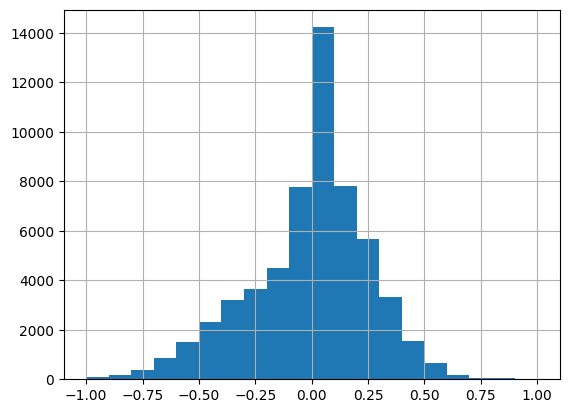

In [13]:
# plot the histogram of the difference between the evaluation score and the predicted score
scatters['diff'] = scatters['evaluation'] - scatters['prediction']
# set hist [-1,-0.9,-0.8,...,0.9,1]
bins = [-1 + 0.1 * i for i in range(21)]
scatters['diff'].hist(bins=bins)
# print each bin's count
for i in range(20):
    print('[{:.1f},{:.1f}): {}'.format(bins[i], bins[i+1], len(scatters[(scatters['diff'] >= bins[i]) & (scatters['diff'] < bins[i+1])])))


In [32]:
# compute the r2 score between the aliases_num and abs_diff

scatters['abs_diff'] = abs(scatters['diff'])
from scipy.stats import pearsonr
pearsonr(scatters['aliases_num'], scatters['abs_diff'])

PearsonRResult(statistic=-0.09443475111106157, pvalue=4.921963234706385e-115)

<Axes: >

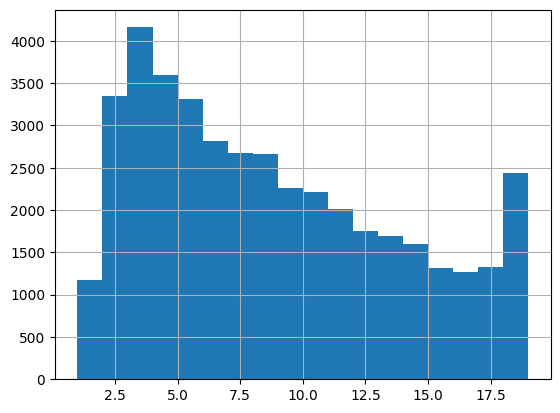

In [39]:
scatters['aliases_num'].hist(bins=range(1, 20))

<Axes: xlabel='aliases_num', ylabel='abs_diff'>

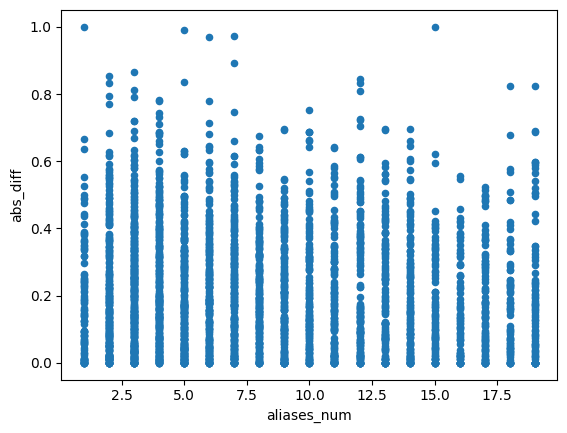

In [41]:
# plot scatter plot between aliases_num and abs_diff sample 1000
scatters[scatters['aliases_num']<20].sample(3000).plot.scatter(x='aliases_num', y='abs_diff')

<Axes: >

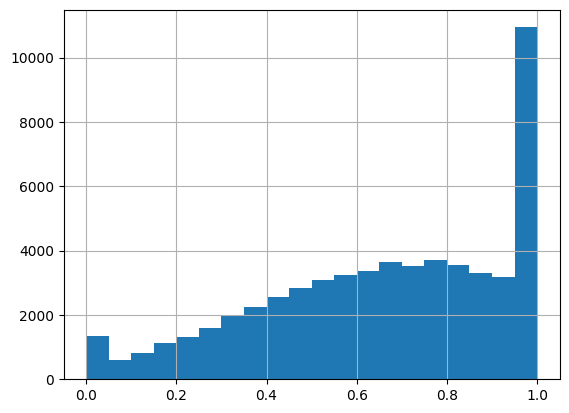

In [14]:
scatters['prediction'].hist(bins=[0.05 * i for i in range(21)])

<Axes: >

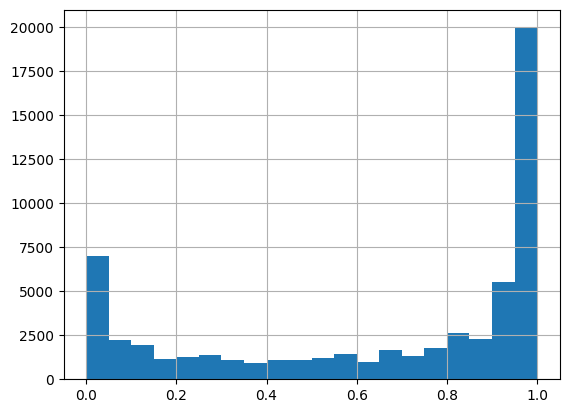

In [15]:
scatters['evaluation'].hist(bins=[0.05 * i for i in range(21)])

Text(0, 0.5, 'evaluation')

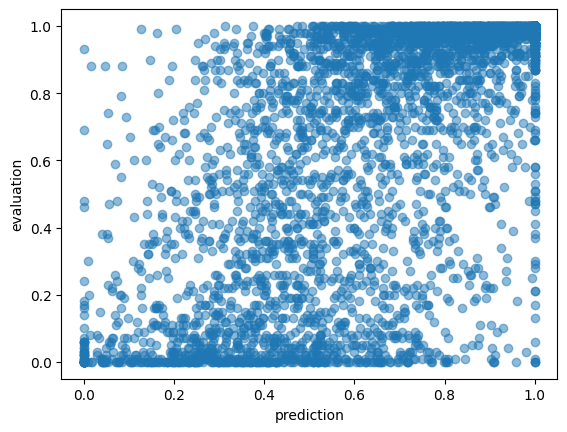

In [16]:
# sample 1000 instances from scatters plot scatter
import matplotlib.pyplot as plt
import numpy as np
sample = scatters[scatters['split'] == 'test'].sample(4000)
plt.scatter(sample['prediction'], sample['evaluation'], alpha=0.5)
plt.xlabel('prediction')
plt.ylabel('evaluation')

<Axes: >

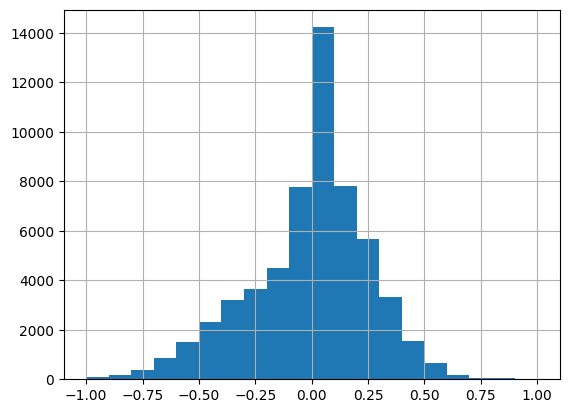

In [17]:
scatters[scatters['answer_type'] == 'WikipediaEntity']['diff'].hist(bins=bins)

In [18]:
# plot the histogram of the difference between the evaluation and the prediction for each answer type
for answer_type in answer_types:
    print(answer_type)
    
    for i in range(20):
        print('[{:.1f},{:.1f}): {}'.format(bins[i], bins[i+1], len(scatters[(scatters['diff'] >= bins[i]) & (scatters['diff'] < bins[i+1])])))
    print()

WikipediaEntity
[-1.0,-0.9): 87
[-0.9,-0.8): 169
[-0.8,-0.7): 382
[-0.7,-0.6): 855
[-0.6,-0.5): 1494
[-0.5,-0.4): 2332
[-0.4,-0.3): 3202
[-0.3,-0.2): 3668
[-0.2,-0.1): 4484
[-0.1,0.0): 7785
[0.0,0.1): 14228
[0.1,0.2): 7825
[0.2,0.3): 5684
[0.3,0.4): 3323
[0.4,0.5): 1550
[0.5,0.6): 651
[0.6,0.7): 190
[0.7,0.8): 57
[0.8,0.9): 40
[0.9,1.0): 12



In [19]:
# find out the evaluation = 0.0
# print the number of evaluation = 0.0
print(len(scatters[scatters['evaluation'] < 0.05]))

7030


In [20]:
# find when evalution = 0 and prediction > 0.5 get the idx
idx_list = scatters[(scatters['evaluation'] > 0.7) & (scatters['prediction'] < 0.2)].index

In [21]:
# bins the prediction
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
scatters['binned'] = pd.cut(scatters['prediction'], bins)
scatters['binned'].value_counts()

binned
(0.8, 1.0]    20931
(0.6, 0.8]    14327
(0.4, 0.6]    11729
(0.2, 0.4]     7126
(0.0, 0.2]     3003
Name: count, dtype: int64

In [22]:
print(len(idx_list))

125


In [23]:
# sample 10 idx
import random
random.seed(42)
idx_list = random.sample(list(idx_list), 10)


In [24]:
# print the text
for idx in idx_list:
    print(json.dumps(text_generation[idx], indent=4))
    print('--------------------------------------')


{
    "qid": 40268,
    "question": "What is the name of the Lagoon that lies between Chesil Beach and the mainland?",
    "answer": {
        "aliases": [
            "Fleet Lagoon",
            "The Fleet Lagoon",
            "Chesil Bank",
            "Chesil, the Fleet and Portland Coast - Dorset and East Devon Coast",
            "Chesil Beach",
            "Chesil Beach and The Fleet"
        ],
        "normalized_aliases": [
            "chesil bank",
            "chesil fleet and portland coast dorset and east devon coast",
            "chesil beach and fleet",
            "fleet lagoon",
            "chesil beach"
        ],
        "matched_wiki_entity_name": "",
        "normalized_matched_wiki_entity_name": "",
        "normalized_value": "fleet lagoon",
        "type": "WikipediaEntity",
        "value": "Fleet Lagoon"
    },
    "model_answers": [
        " There is no lagoon that lies between Chesil Beach and the mainland. Chesil Beach is a long, narrow shingle beach th